# Initial steps towards interactive visualisation
[Return to Table of Contents](./0_Table_of_contents.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

Let' assume that we conducted some multichannel recording of brain activity and it is stored in `csv` format. We would normally use `pandas` to read content of the file before we start to analyse data

In [3]:
import pandas as pd
df_data_raw = pd.read_csv("../data/EEG_recording_trial_1.csv")
df_data_raw.head()

,Timestamp,Channel,FrequencyBand,Response
0,0,0,0,0.0
1,0,0,1,0.0
2,0,0,2,0.0
3,0,0,3,0.0
4,0,0,4,0.0


In [4]:
df_data_raw.describe()

,Timestamp,Channel,FrequencyBand,Response
count,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,249.500000,4.500000,99.500000,-1.981748e-20
std,144.337351,2.872283,57.734334,4.169809e-01
min,0.000000,0.000000,0.000000,-2.760074e+00
25%,124.750000,2.000000,49.750000,-1.843469e-01
50%,249.500000,4.500000,99.500000,0.000000e+00
75%,374.250000,7.000000,149.250000,1.843469e-01
max,499.000000,9.000000,199.000000,2.760074e+00


In [5]:
df_data_raw["Response"].plot();

It looks like there is some structure in a data. Let's plot different combinations of channels and frequency bands. But wait, we have 10 * 200 = 2000 possible combinations. Well, let's select only 6 and hope that we will get lucky and will get some insights.

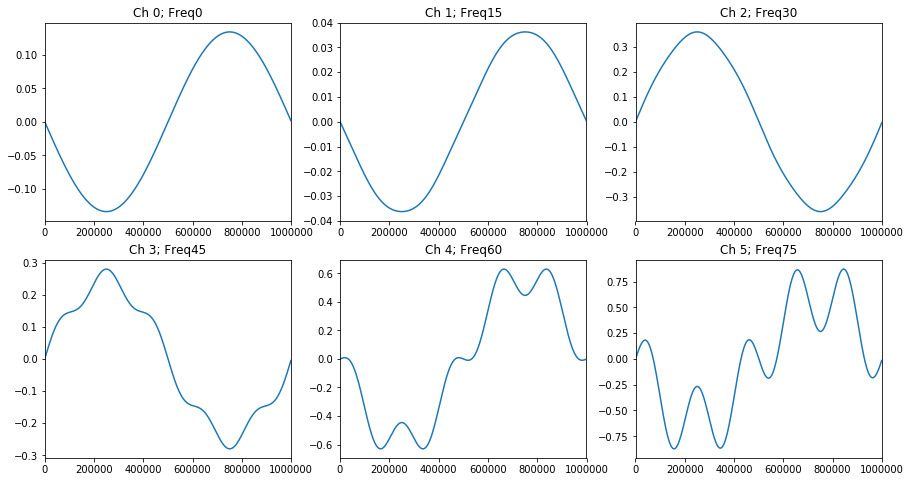

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    channel = i
    frequency_band = i * 15
    ax = fig.add_subplot(2, 3, i+1)
    df_data_raw[
        (df_data_raw["Channel"] == channel) & 
        (df_data_raw["FrequencyBand"] == frequency_band)
    ]["Response"].plot(ax=ax)
    ax.set_title("Ch {channel}; Freq{frequency}".format(channel=channel, frequency=frequency_band))

Hmmm... not really helpfull. How is about to group data by `"Timestamp", "Channel", "FrequencyBand"`, aka multi-index data frame.

In [7]:
df_data = df_data_raw.set_index(["Timestamp", "Channel", "FrequencyBand"])
df_data.head()

Response
Timestamp Channel FrequencyBand          
0         0       0                   0.0
                  1                   0.0
                  2                   0.0
                  3                   0.0
                  4                   0.0

But wait, isn't multi-index dataframe equivalent to mutli-dimensional array. Spot on, you see right through where we are going. Convert dataframe to `Tensor`, apply tensor decomposition and visually inspect results.

In [8]:
from hottbox.pdtools import pd_to_tensor

tensor_data = pd_to_tensor(df_data, keep_index=True)
tensor_data

This tensor is of order 3 and consists of 1000000 elements.
Sizes and names of its modes are (500, 10, 200) and ['Timestamp', 'Channel', 'FrequencyBand'] respectively.

In [9]:
from hottbox.algorithms.decomposition import CPD

cpd = CPD()
tensor_cpd_data = cpd.decompose(tensor_data, rank=(3,), keep_meta=True)
tensor_cpd_data

Kruskal representation of a tensor with rank=(3,).
Factor matrices represent properties: ['Timestamp', 'Channel', 'FrequencyBand']
With corresponding latent components described by (500, 10, 200) features respectively.

In [10]:
from hottbox.contrib.visualisation import ComponentPlotCPD

p = ComponentPlotCPD(tensor_cpd_data)

Only to types of plots... can we define custom functions to plot data. Sure, we got you coverted.

In [11]:
def my_line_plot(ax, data):
    """
    ax : Axes object which is used to illustrate `data`  
    data : selected factor vector to be plotted
    """    
    ax.plot(data, 'r+')
    
custom_plots = {"my line": my_line_plot}  # key will be displayed in the dropdown menu
p.extend_available_plots(custom_plots)    # will be available for all modes

How is about `stem` plots for representation of frequencies??? 

In [12]:
def my_stem_plot(ax, data):
    """
    ax : Axes object which is used to illustrate `data`  
    data : selected factor vector to be plotted
    """    
    ax.stem(data)
    
custom_plots = {"my stem": my_stem_plot}              # key will be displayed in the dropdown menu
p.extend_available_plots(custom_plots, modes=[2])     # will be available for mode associated with frequency

Nice, but what if I want to use some other library, not `matplotlib`. Sure, no problem, as long as it can be integrated into the universe of `matplotlib`, i.e based on the use of `Axes`.

In [13]:
import mne  # `hottbox` does not depend on this package

def my_topo_plot(ax, data):
    """
    ax : Axes object which is used to illustrate `data`  
    data : selected factor vector to be plotted
    """
    ch_names = ['Cz', 'Oz', 'T7', 'FT9', 'T8', 'FT10', 'M1', 'M2']
    info = mne.create_info(ch_names=ch_names, sfreq=1200, ch_types='eeg', verbose=False)
    montage = mne.channels.read_montage("standard_1020")
    temp = data.reshape(-1, 1)
    temp = temp [:8,:]
    
    
    raw = mne.io.RawArray(temp, info, verbose=False)
    raw.set_montage(montage)
    raw.set_eeg_reference("average", projection=False)
    temp = data[:8]
        
    im = mne.viz.plot_topomap(temp,
                              raw.info,
                              names=ch_names,
                              axes=ax,
                              show_names=False,
                              cmap='RdBu_r',
                              sensors='k.',
                              outlines='head',
                              show=False
                        )
    
custom_plots = {"my topo": my_topo_plot}  # key will be displayed in the dropdown menu
p.extend_available_plots(custom_plots, modes=[1]) # will be available only for the channel mode

Something is still off... Ahhh, figure titles? Of course, now we plot components of Kruskal representation of a multi-dimensional array, where each factor vector/matrix has slightly different meaning to what we started from.

In [14]:
new_mode_names = {
    0: "Evolution in Time",
    1: "Distribution across channels",
    2: "Frequency response"
}

tensor_cpd_data.set_mode_names(new_mode_names)

Kruskal representation of a tensor with rank=(3,).
Factor matrices represent properties: ['Evolution in Time', 'Distribution across channels', 'Frequency response']
With corresponding latent components described by (500, 10, 200) features respectively.

Fantastic) Shall we try to represent original, raw data through different tensor decomposition? What the heck, why not)

In [15]:
from hottbox.algorithms.decomposition import HOSVD

hosvd = HOSVD()
tensor_tkd_data = hosvd.decompose(tensor_data, rank=(5,7,10), keep_meta=True)
tensor_tkd_data

Tucker representation of a tensor with multi-linear rank=(5, 7, 10).
Factor matrices represent properties: ['Timestamp', 'Channel', 'FrequencyBand']
With corresponding latent components described by (500, 10, 200) features respectively.

In [16]:
from hottbox.contrib.visualisation import ComponentPlotTKD

p2 = ComponentPlotTKD(tensor_tkd_data)

In [17]:
custom_plots = {"my line": my_line_plot}  # key will be displayed in the dropdown menu
p2.extend_available_plots(custom_plots)  # will be available for all modes

In [18]:
custom_plots = {"my stem": my_stem_plot}  # key will be displayed in the dropdown menu
p2.extend_available_plots(custom_plots, modes=[2])  # will be available for frequency mode

In [19]:
custom_plots = {"my topo": my_topo_plot}  # key will be displayed in the dropdown menu
p2.extend_available_plots(custom_plots, modes=[1]) # will be available only for the channel mode